In [5]:
import pandas as pd
import numpy as np
import timm
import torchvision.transforms as T
import torch
import itertools
from torch.optim import SGD
from transformers import AutoImageProcessor, AutoModel
import torch.nn as nn

from wildlife_tools.train import ArcFaceLoss, BasicTrainer, set_seed, TripletLoss, InfoNCELoss
from wildlife_tools.features import DeepFeatures
from wildlife_tools.data import ImageDataset


In [ ]:


# Load metadata
PT_CSV = '/home/users/dash/guppies/embeddings/wildlife-tools/exploring/csvs/top_1000_individuals.csv'
PT_images = '/gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks'
PT_storage = '/gws/nopw/j04/iecdt/dash/embeddings'
df = pd.read_csv(PT_CSV)
# df['path'] = df['path'].str.replace('.JPG','.png', case=False)
# df.to_csv(PT_CSV, index=False)
df.head()

,identity,path,date
0,63498,1706/Lower Lalaja/29A/DCIM/121D7100/DSC_8870.png,2017-06-29
1,63498,1803/LL/26B/123D7100/DSC_3857.png,2018-03-26
2,63498,1804/LL/27B/DSC_5389.png,2018-04-27
3,63498,1802/LL/26B/DSC_0428.png,2018-02-26
4,63498,1806/LL/28A/100D7100/DSC_9352.png,2018-06-28


# Model setup

In [12]:
# Load the MegaDescriptor model
# backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-L-384', pretrained=True, num_classes=0)
# backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', pretrained=True, num_classes=0)


# Load the processor and model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small', use_fast=True)
backbone = AutoModel.from_pretrained('facebook/dinov2-small')


In [4]:
import pynvml

pynvml.nvmlInit()
device_count = torch.cuda.device_count()
max_free_mem = 0
best_device = 0

for i in range(device_count):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    if mem_info.free > max_free_mem:
        max_free_mem = mem_info.free
        best_device = i

device = torch.device(f'cuda:{best_device}')
print(f'using gpu {device} out of {torch.cuda.device_count()}')

using gpu cuda:2 out of 4


In [13]:

# Define image transformations
transform = T.Compose([
    T.Resize((224, 224)),  # Resize to match MegaDescriptor-L-384 input
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transform_dino = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Create the dataset
# Split dataset into query and database sets
query_df = df.sample(frac=0.2, random_state=42)
database_df = df.drop(query_df.index)
# Save the query and database splits to CSV files
query_df.to_csv(PT_CSV[:-4] + '_query.csv', index=False)
database_df.to_csv(PT_CSV[:-4] + '_database.csv', index=False)

# Create ImageDataset instances
query_dataset = ImageDataset(query_df, root=PT_images, transform=transform_dino)
database_dataset = ImageDataset(database_df, root=PT_images, transform=transform_dino)

In [6]:
# Define a wrapper to extract features
class DINOv2Wrapper(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone

    def forward(self, x):
        # Extract the last hidden state
        outputs = self.backbone(x)
        # Use the [CLS] token representation
        return outputs.last_hidden_state[:, 0]

In [27]:
# check images work!!!!!
from PIL import Image

# Function to check if all images in a dataset can be opened
def check_images(dataset, root):
    failed = []
    for idx in range(len(dataset)):
        img_path = dataset.iloc[idx]['path']
        full_path = f"{root}/{img_path}"
        print(f"Checking image: {full_path}")
        try:
            with Image.open(full_path) as img:
                img.verify()  # Verify that it is, in fact, an image
        except Exception as e:
            print(f"Failed to open: {full_path} ({e})")
            failed.append(full_path)
    if not failed:
        print("All images opened successfully!")
    else:
        print(f"{len(failed)} images failed to open.")
    return failed

print("Checking database_dataset...")
failed_db = check_images(database_df, PT_images)

print("Checking query_dataset...")
failed_query = check_images(query_df, PT_images)

Checking database_dataset...
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1706/Lower Lalaja/29A/DCIM/121D7100/DSC_8870.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1803/LL/26B/123D7100/DSC_3857.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1804/LL/27B/DSC_5389.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1802/LL/26B/DSC_0428.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1806/LL/28A/100D7100/DSC_9352.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1807/LL/26B/124D7100/DSC_2617.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1902/LL/27B/110D7100.1/DSC_4155.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1901/Lower Lalaja/27B/DSC_2536.png
Checking image: /gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks/1908/Lower Lalaja/27B/DSC_0257.pn

# Training

In [ ]:
"""
Wraps Pytorch Metric Learning ArcFaceLoss.

Args:
    num_classes (int): Number of classes.
    embedding_size (int): Size of the input embeddings.
    margin (int): Margin for ArcFace loss (in radians).
    scale (int): Scale parameter for ArcFace loss.
"""
# Define the loss function
objective = ArcFaceLoss(
    num_classes=database_dataset.num_classes,
    embedding_size=backbone.config.hidden_size,
    margin=0.5,
    scale=64
)


'''
Args:
    margin (int): Margin for triplet loss.
    mining (str): Type of triplet mining. One of: 'all', 'hard', 'semihard'
    distance (str): Distance metric for triplet loss. One of: 'cosine', 'l2', 'l2_squared'''

objective = TripletLoss(
    margin=0.5,
    mining='semihard',
    distance='l2_squared'
)

objective = InfoNCELoss(temperature=0.1)


# Define the optimizer
params = itertools.chain(backbone.parameters(), objective.parameters())
optimizer = SGD(params=params, lr=0.001, momentum=0.9)

# Set the seed for reproducibility
set_seed(0)
epochs = 20
# Initialize the trainer
trainer = BasicTrainer(
    dataset=database_dataset,
    model=DINOv2Wrapper(backbone),
    objective=objective,
    optimizer=optimizer,
    epochs=epochs,
    device=device)

In [24]:
# Start training
trainer.train()

Epoch 19: 100%|███████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.56s/it]


In [ ]:
# Save the model's state_dict
torch.save(backbone.state_dict(), PT_storage+f'/DINO_{epochs}_epoch_infonce.pth')

# Inference

In [26]:
model = DINOv2Wrapper(backbone)
model.to(device)

extractor = DeepFeatures(model, device=device)

# Extract features
with torch.no_grad():
    features = extractor(database_dataset)


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.63s/it]


In [27]:
assert len(features) == len(database_dataset)
assert tuple(features.features.shape) == (len(database_dataset), 384) # 768 for base model, 384 for small model

In [28]:
# Convert embeddings to NumPy array
embeddings = features.features
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.detach().cpu().numpy()

# Extract labels
labels = features.labels_string  # Assuming labels are stored here

# TSNE

In [29]:
from sklearn.manifold import TSNE

# Determine the number of samples
n_samples = embeddings.shape[0]

# Set perplexity to a value less than n_samples
perplexity_value = min(5, n_samples - 1)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(embeddings)


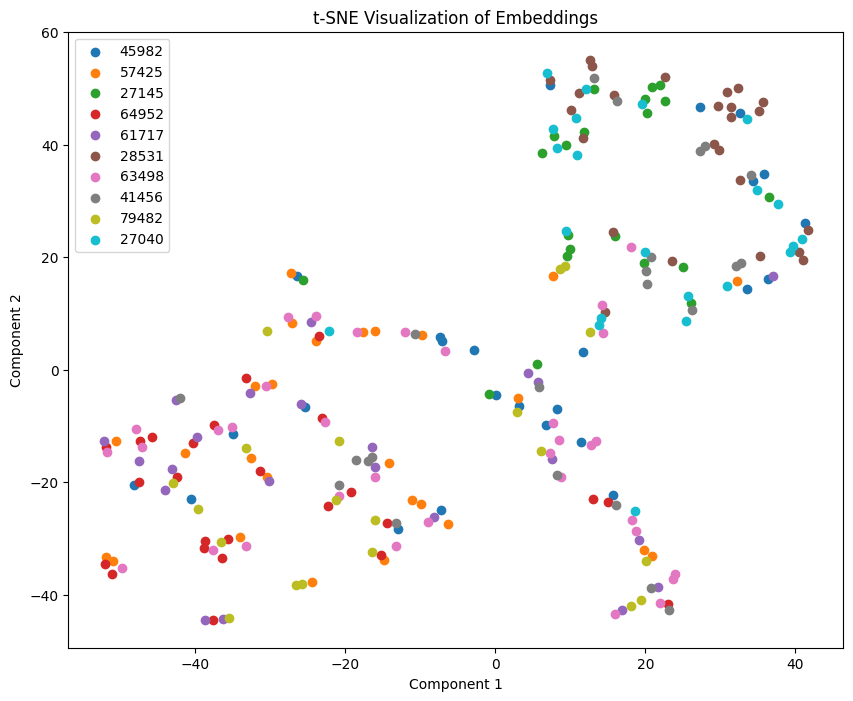

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
unique_labels = set(labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [32]:
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier
import numpy as np



# Extract features
query_features = extractor(query_dataset)
database_features = features
# database_features = extractor(database_dataset)


  0%|                                                                         | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


# Cosine similarity

In [33]:

# Compute cosine similarity
similarity_function = CosineSimilarity()
similarity = similarity_function(query_features, database_features)

# Perform 1-NN classification
classifier = KnnClassifier(k=1, database_labels=database_dataset.labels_string)
predictions = classifier(similarity)

# Evaluate accuracy
accuracy = np.mean(np.array(query_dataset.labels_string) == np.array(predictions))
print(f'1-NN Classification Accuracy: {accuracy:.2%}')


1-NN Classification Accuracy: 22.95%


In [34]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)
# Initialize dictionaries to hold similarities
same_identity_sims = defaultdict(list)
different_identity_sims = defaultdict(list)

num_embeddings = len(embeddings)

for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        sim = similarity_matrix[i][j]
        if labels[i] == labels[j]:
            same_identity_sims[labels[i]].append(sim)
        else:
            key = f"{labels[i]} vs {labels[j]}"
            different_identity_sims[key].append(sim)

# Compute average similarities
avg_same_identity_sim = np.mean([np.mean(sims) for sims in same_identity_sims.values()])
avg_different_identity_sim = np.mean([np.mean(sims) for sims in different_identity_sims.values()])

print(f"Average similarity within the same identity: {avg_same_identity_sim:.4f}")
print(f"Average similarity between different identities: {avg_different_identity_sim:.4f}")

Average similarity within the same identity: 0.9323
Average similarity between different identities: 0.8494


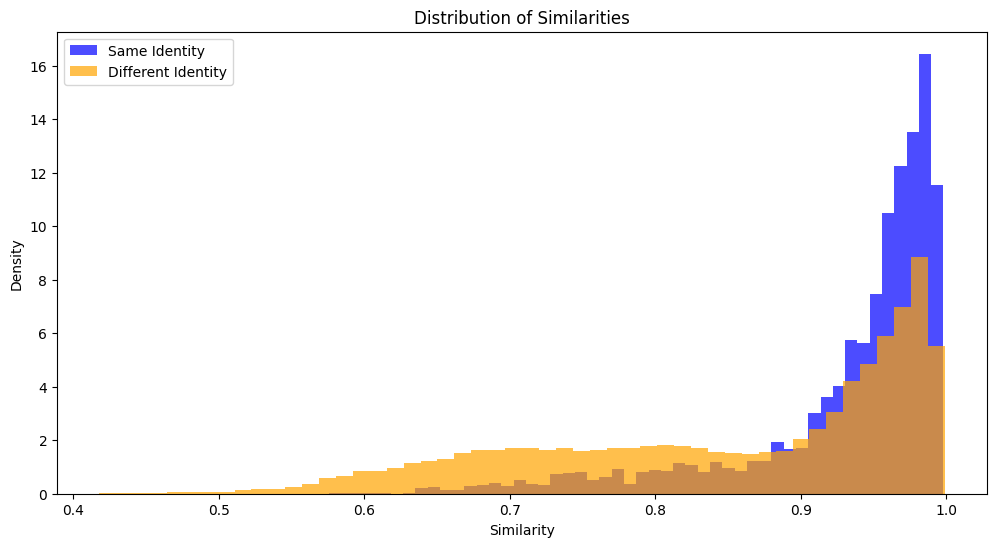

In [35]:
plt.figure(figsize=(12, 6))

# Flatten the lists of similarities
same_identity_flat = [sim for sims in same_identity_sims.values() for sim in sims]
different_identity_flat = [sim for sims in different_identity_sims.values() for sim in sims]

# Plot histograms
plt.hist(same_identity_flat, bins=50, alpha=0.7, label='Same Identity', color='blue', density=True)
plt.hist(different_identity_flat, bins=50, alpha=0.7, label='Different Identity', color='orange', density=True)

# Add labels and legend
plt.title('Distribution of Similarities')
plt.xlabel('Similarity')
plt.ylabel('Density')
plt.legend()

plt.show()

# euclidean distance

In [36]:
from scipy.spatial.distance import cdist

# Calculate pairwise distances
# Yes, if you want to compute distances between the query and database embeddings (not within the same set), you should do:
distances = cdist(query_features.features, database_features.features, metric='euclidean')

In [37]:
from sklearn.preprocessing import MinMaxScaler

# Normalize distances using Min-Max scaling
scaler = MinMaxScaler()
normalized_distances = scaler.fit_transform(distances)

In [38]:
# For each query, find the database sample with the smallest distance (1-NN)
knn_predictions = []
for i in range(distances.shape[0]):
    min_idx = np.argmin(distances[i])
    knn_predictions.append(database_dataset.labels_string[min_idx])

# Calculate accuracy
knn_accuracy = np.mean(np.array(query_dataset.labels_string) == np.array(knn_predictions))
print(f'1-NN Classification Accuracy (using distances): {knn_accuracy:.2%}')

1-NN Classification Accuracy (using distances): 22.95%
